In [73]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [74]:
features_df = pd.read_parquet("data/contribution_data/extracted_features.parquet")

In [75]:
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,emergency,geological,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,0,0,True
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,0,0,True
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,0,0,1,0,0,0,True
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,0,0,1,0,0,True
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,0,0,True


In [76]:
if features_df.columns.__contains__('xzcode'):
    # Split 'xzcode' column into two separate columns 'code' and 'level'
    features_df[['code', 'level']] = pd.json_normalize(features_df['xzcode'])
    features_df.drop('xzcode', axis=1, inplace=True)
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [77]:
features_df.members.unique()

array([None], dtype=object)

In [78]:
if features_df.columns.__contains__('geometry'):
    features_df.drop('geometry', axis=1, inplace=True)
    
if features_df.columns.__contains__('osm_id'):
    features_df.drop('osm_id', axis=1, inplace=True)
    
    
if features_df.columns.__contains__('members'):
    features_df.drop('members', axis=1, inplace=True)
    
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [79]:
features_df.columns = features_df.columns.str.replace(' ', '_', regex=True)
features_df.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,healthcare,highway,historic,landuse,leisure,man_made,military,vandalism,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,True,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,True,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,1,0,0,0,True,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,1,0,0,True,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,True,1391593370,16


In [80]:
X = features_df.drop('vandalism', axis=1).copy()
X.head()

,user_id,user_edit_frequency,editor_used,area_delta,length_delta,area,length,bounding_box_size,geometry_valid,xmax,...,geological,healthcare,highway,historic,landuse,leisure,man_made,military,code,level
0,2377515,32.000000,iD 1.5.4,-597,0,0,0,1.180083e-05,0,-62.976084,...,0,0,0,0,0,0,0,0,384395826,14
1,2377515,32.000000,iD 1.5.4,-661,0,0,0,1.543374e-05,0,-62.956141,...,0,0,0,0,0,0,0,0,384395847,14
2,6335199,5.490196,iD 2.5.1,-6351,0,0,0,7.911717e-06,0,-90.207543,...,0,0,0,0,1,0,0,0,3209861041,15
3,5193146,3.762032,JOSM,-60560,0,0,0,3.357874e-05,0,-0.898112,...,0,0,0,0,0,1,0,0,3576265364,15
4,3149129,3791.000000,JOSM,-47,0,0,0,5.833380e-09,0,-34.881410,...,0,0,0,0,0,0,0,0,1391593370,16


In [81]:
y = features_df['vandalism'].copy()
y.head()

0    True
1    True
2    True
3    True
4    True
Name: vandalism, dtype: bool

In [82]:
X_encoded = pd.get_dummies(X, columns=['source_reliability',
                                       'historical_validity',
                                       'country_count',
                                       'population_changed',
                                       'boundary_changed',
                                       'name_changed',
                                       'tags_modified',
                                       'tags_added',
                                       'tags_removed',
                                       'edit_time_of_day',
                                       'geometry_valid',
                                       'editor_used',
                                       'osm_type',
                                       'contribution_type',
                                       'status'])
X_encoded.head()

,user_id,user_edit_frequency,area_delta,length_delta,area,length,bounding_box_size,xmax,xmin,ymax,...,osm_type_way,contribution_type_CREATED,contribution_type_DELETED,contribution_type_GEOMETRY,contribution_type_NONE,contribution_type_TAG,contribution_type_TAG_GEOMETRY,status_deleted,status_history,status_latest
0,2377515,32.000000,-597,0,0,0,1.180083e-05,-62.976084,-62.996941,-84.906087,...,True,False,True,False,False,False,False,True,False,False
1,2377515,32.000000,-661,0,0,0,1.543374e-05,-62.956141,-62.975782,-84.905873,...,True,False,True,False,False,False,False,True,False,False
2,6335199,5.490196,-6351,0,0,0,7.911717e-06,-90.207543,-90.209129,38.525163,...,True,False,True,False,False,False,False,True,False,False
3,5193146,3.762032,-60560,0,0,0,3.357874e-05,-0.898112,-0.907923,41.659127,...,True,False,True,False,False,False,False,True,False,False
4,3149129,3791.000000,-47,0,0,0,5.833380e-09,-34.881410,-34.881507,-8.043102,...,True,False,True,False,False,False,False,True,False,False


In [83]:
X_encoded.dtypes.__contains__('object')

False

In [84]:
y = y.replace(True, 1)
y = y.replace(False, 0)

C:\Users\saise\AppData\Local\Temp\ipykernel_13948\3107921932.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace(False, 0)


In [85]:
y.dtype

dtype('int64')

In [86]:
sum(y) / len(y)

0.6621638875411762

In [87]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state=42, stratify=y)

In [88]:
# Get the shapes of the datasets
shapes = {
    'X_train shape': X_train.shape,
    'X_test shape': X_test.shape,
    'y_train shape': y_train.shape,
    'y_test shape': y_test.shape
}

# Convert shapes to DataFrame for better display
shapes_df = pd.DataFrame(shapes, index=['Number of Samples', 'Number of Features']).T
print(shapes_df)

               Number of Samples  Number of Features
X_train shape             352449                 586
X_test shape              117483                 586
y_train shape             352449              352449
y_test shape              117483              117483


In [89]:
sum(y_train)/len(y_train)

0.6621638875411762

In [90]:
sum(y_test)/len(y_test)

0.6621638875411762

In [91]:
import xgboost as xgb

# Convert the datasets to DMatrix format
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Specify model parameters with both 'aucpr' and 'accuracy'
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': ['aucpr', 'error'],  # 'error' is 1 - accuracy
    'seed': 42
}

# Set up the evaluation set
evals = [(dtest, 'eval')]

# Train the model with early stopping
bst = xgb.train(params, dtrain, num_boost_round=100, evals=evals,
                early_stopping_rounds=15, verbose_eval=True)


[0]	eval-aucpr:0.95554	eval-error:0.20160
[1]	eval-aucpr:0.97030	eval-error:0.14794
[2]	eval-aucpr:0.98102	eval-error:0.11248
[3]	eval-aucpr:0.98296	eval-error:0.10394
[4]	eval-aucpr:0.98398	eval-error:0.09724
[5]	eval-aucpr:0.98606	eval-error:0.09063
[6]	eval-aucpr:0.98706	eval-error:0.08387
[7]	eval-aucpr:0.98784	eval-error:0.08079
[8]	eval-aucpr:0.98825	eval-error:0.08155
[9]	eval-aucpr:0.98858	eval-error:0.08024
[10]	eval-aucpr:0.98878	eval-error:0.07852
[11]	eval-aucpr:0.99047	eval-error:0.07053
[12]	eval-aucpr:0.99077	eval-error:0.06973
[13]	eval-aucpr:0.99117	eval-error:0.06890
[14]	eval-aucpr:0.99212	eval-error:0.06186
[15]	eval-aucpr:0.99229	eval-error:0.06060
[16]	eval-aucpr:0.99233	eval-error:0.06079
[17]	eval-aucpr:0.99279	eval-error:0.05705
[18]	eval-aucpr:0.99325	eval-error:0.05477
[19]	eval-aucpr:0.99342	eval-error:0.05378
[20]	eval-aucpr:0.99364	eval-error:0.05268
[21]	eval-aucpr:0.99391	eval-error:0.05116
[22]	eval-aucpr:0.99423	eval-error:0.04998
[23]	eval-aucpr:0.994

In [92]:
# Make predictions on the test data
y_pred_proba = bst.predict(dtest)  # Get predicted probabilities
y_pred = np.where(y_pred_proba > 0.5, 1, 0)  # Convert probabilities to binary predictions


Statistics:
True Negatives (TN): 38972
False Positives (FP): 718
False Negatives (FN): 982
True Positives (TP): 76811
Accuracy: 0.9855
Precision: 0.9907
Recall: 0.9874
F1 Score: 0.9891


<Figure size 800x600 with 0 Axes>

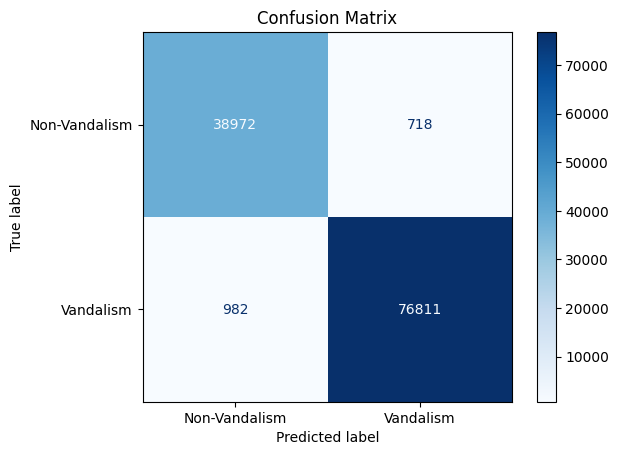

In [93]:
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Calculate additional statistics
TN, FP, FN, TP = cm.ravel()  # Unpack the confusion matrix
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print statistics
print(f"\nStatistics:")
print(f"True Negatives (TN): {TN}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Positives (TP): {TP}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Non-Vandalism', 'Vandalism']).plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()